1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

#### 1. Подготовка датасета: 

In [1]:
!pip install segmentation_models_pytorch

In [2]:
# загружаю библиотеки: 

import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils

Text(0.5, 1.0, 'True mask')

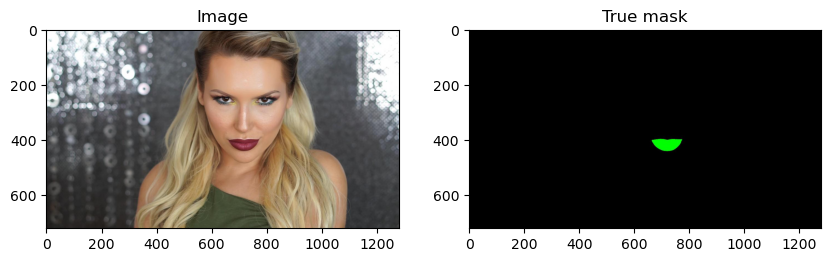

In [3]:
# определяю пути, вывожу примеры оригинала и маски: 

root_path = '/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original'
imgs_path = root_path + '/720p'
masks_path = root_path + '/mask'
csv_path = root_path + '/list.csv'

sample = plt.imread(imgs_path + '/image00000001.jpg')
mask = plt.imread(masks_path + '/mask00000001.png')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(sample)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('True mask')

In [4]:
# загружаю csv-датасет: 

df_lips_images = pd.read_csv(csv_path)
df_lips_images.head()

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

In [5]:
# сравниваю количество картинок и количество масок: 

list_of_an_images = sorted([i for i in Path(imgs_path).iterdir()])
list_of_a_masks = sorted([i for i in Path(masks_path).iterdir()])

len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [6]:
# удаляю картинки без масок: 

df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)

df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [7]:
# создаю функцию для ресайза картинок и масок: 

def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    image = cv2.imread(imgs_path + '/' + image_filename)
    mask = cv2.imread(masks_path + '/' + mask_filename)
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask

In [8]:
# определеляю размер изображений: 

img_size = 256

In [9]:
# создаю класс кастомного датасета: 

class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, -1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, img_size)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        
        return img.float(), masks

In [10]:
# определяю устройство: 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

**resnet50/Unet:**

In [11]:
# определяю энкодер и модель: 
# сначала resnet50 и Unet: 

BACKBONE = 'resnet50'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [12]:
# разбиваю датасет на обучающую и валидационную выборки, сбрасываю индексы: 

X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [13]:
# создаю датасеты - экземпляры класса датасета LipsDataset: 

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [14]:
# создаю обучающий и валидационный даталоадер: 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

/tmp/ipykernel_284/4148995924.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.float)


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


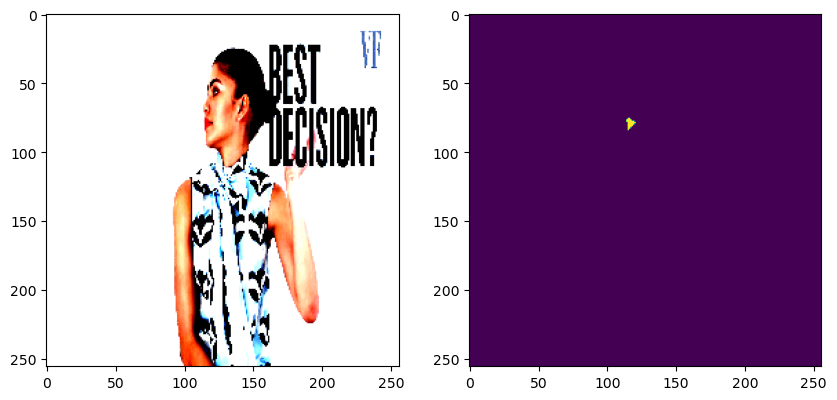

In [15]:
# проверяю размеры оригиналов и масок, вывожу пример пары: 

for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

#### 2. Обучение модели: 

In [16]:
# задаю функцию потерь, метрику и оптимизирующую функцию: 

criterion = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [17]:
# использую реализованные циклы обучения: 

train_epoch = utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [18]:
# обучение модели: 

max_score = 0

for i in range(1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model_1.pth')
        print('Model saved!') # сохранение модели

Epoch: 1
valid: 100%|██████████| 2141/2141 [06:27<00:00,  5.52it/s, dice_loss - 0.0706, iou_score - 0.876]  
Model saved!


In [19]:
# делаю предсказания: 

data_iter = iter(train_loader)

images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

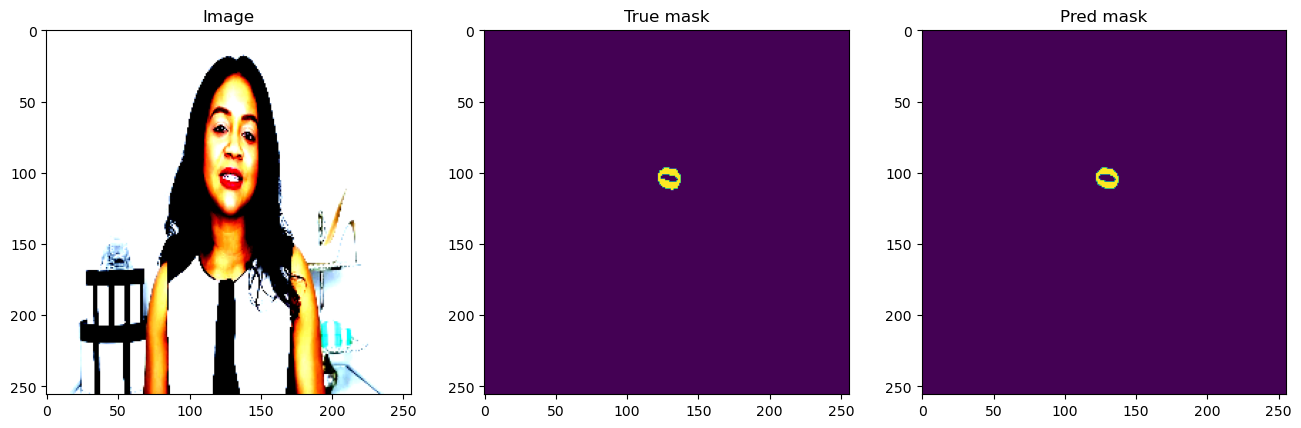

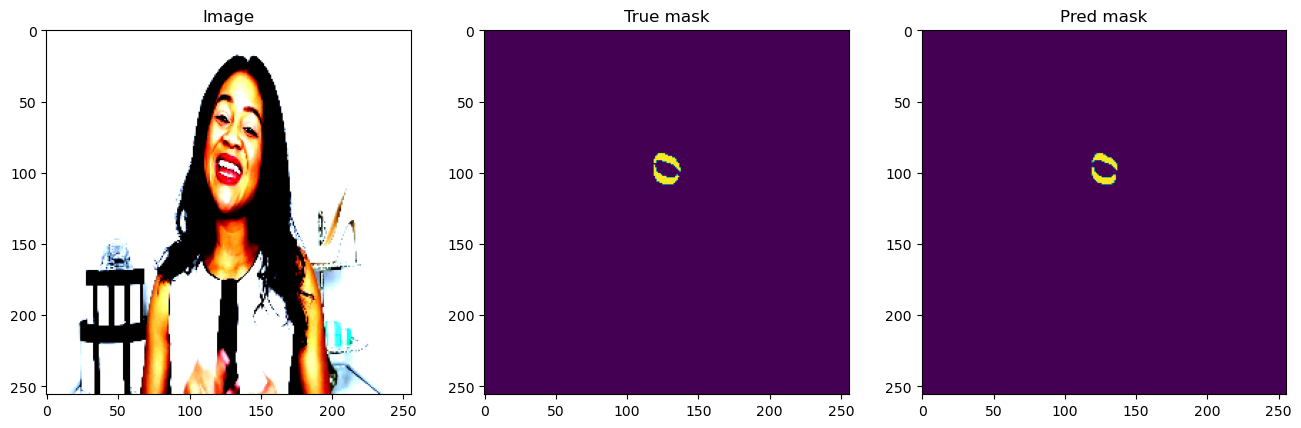

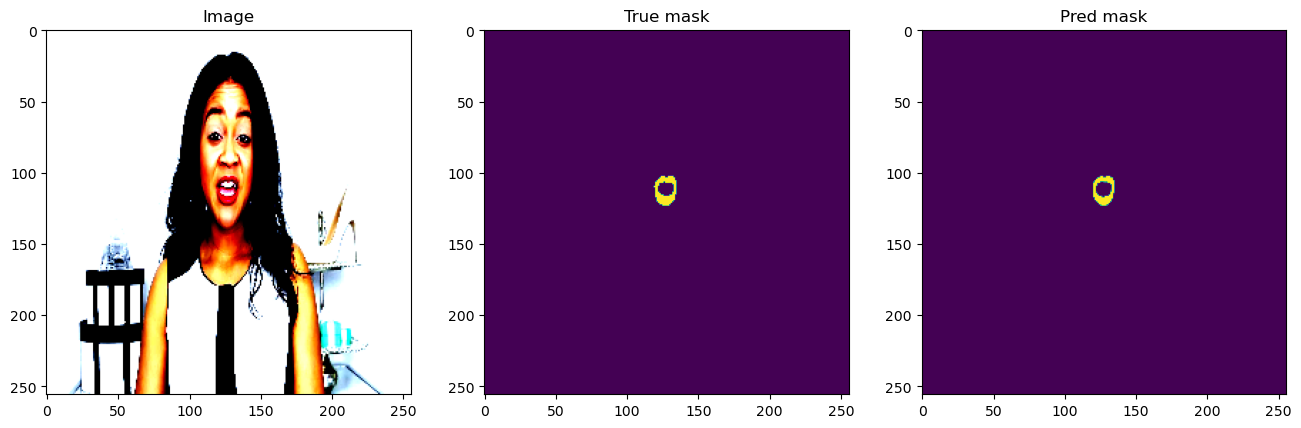

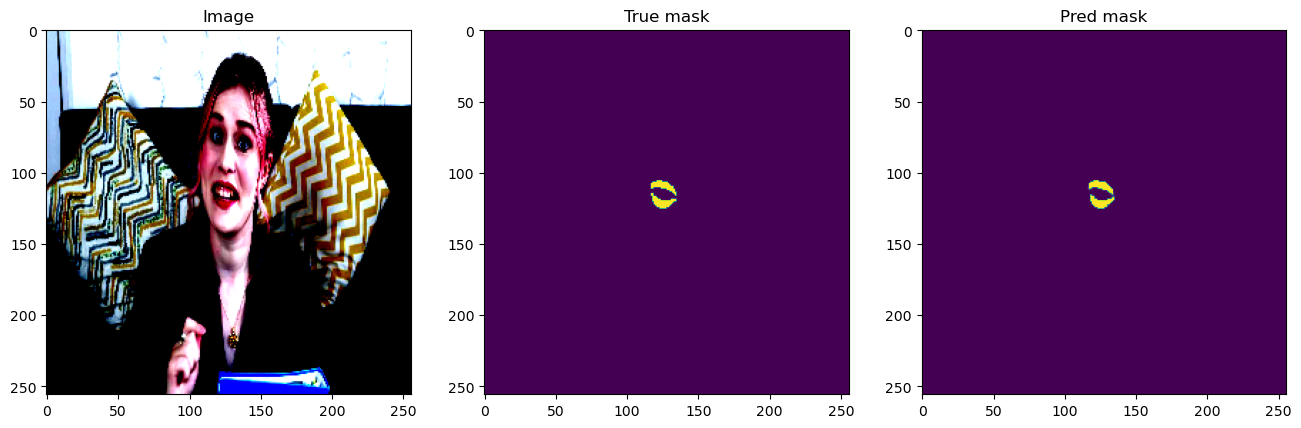

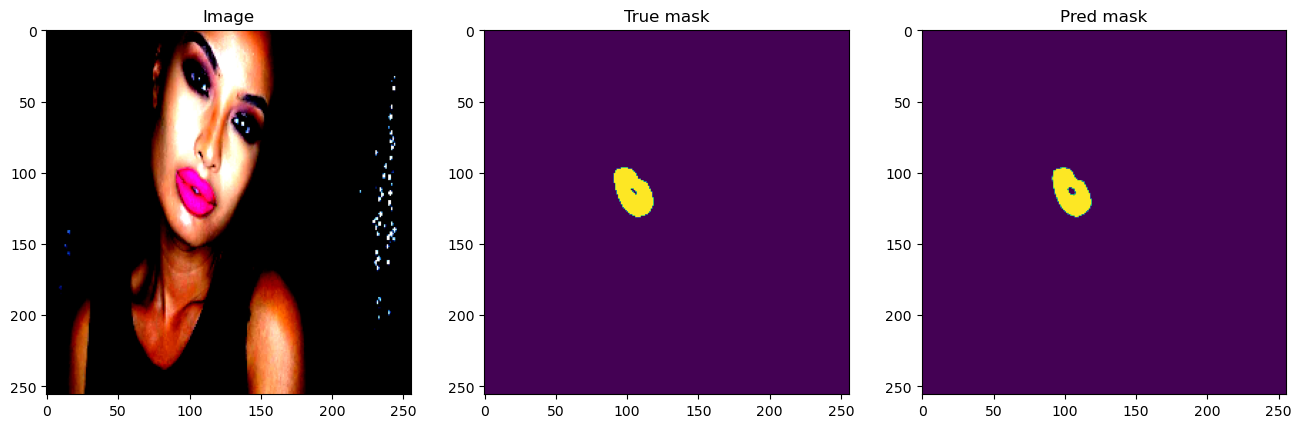

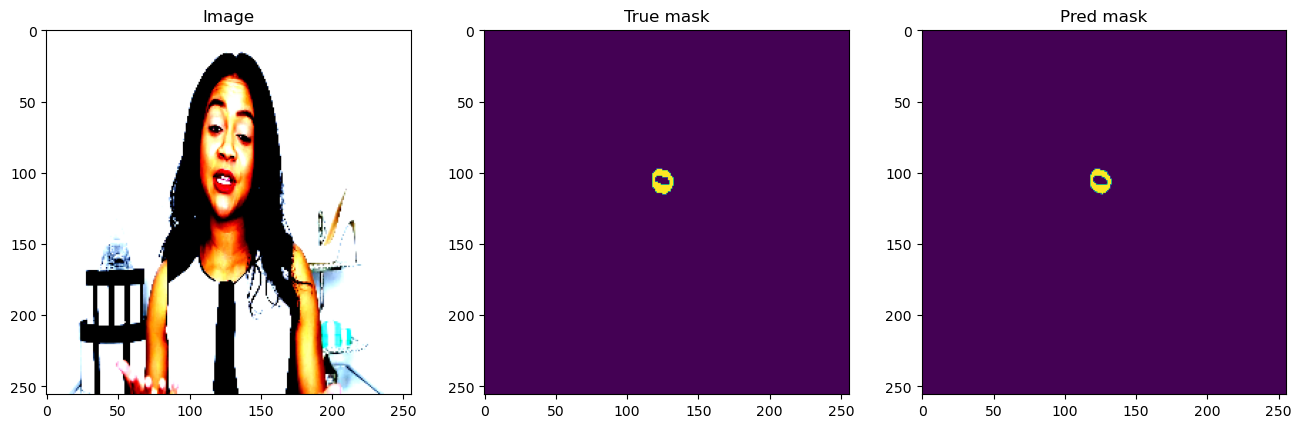

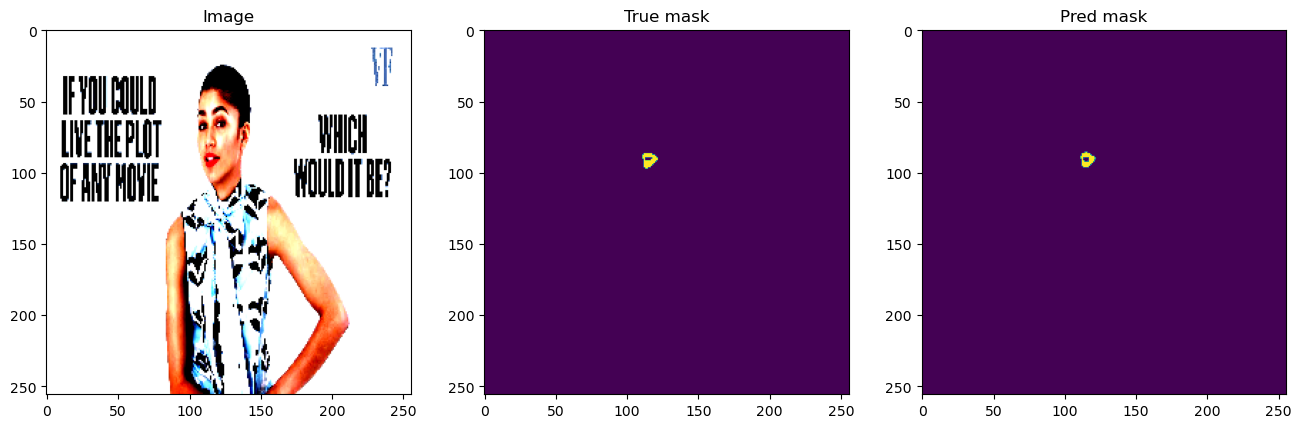

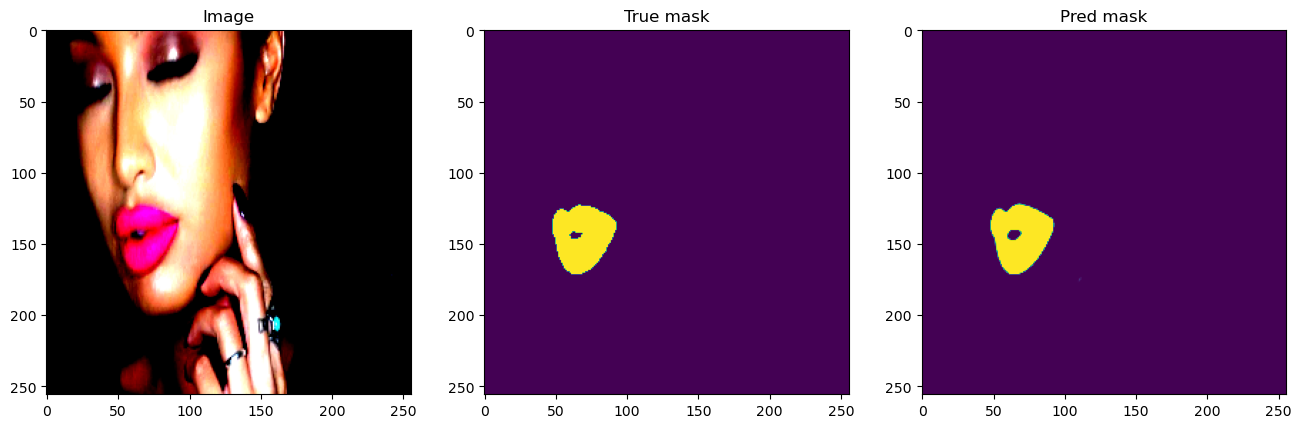

In [20]:
# отрисовываю результаты: 

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')

**vgg19/Unet:**

In [21]:
# определяю энкодер и модель: 
# теперь vgg19 и Unet: 

BACKBONE = 'vgg19'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [22]:
# разбиваю датасет на обучающую и валидационную выборки, сбрасываю индексы: 

X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [23]:
# создаю датасеты - экземпляры класса датасета LipsDataset: 

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [24]:
# создаю обучающий и валидационный даталоадер: 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


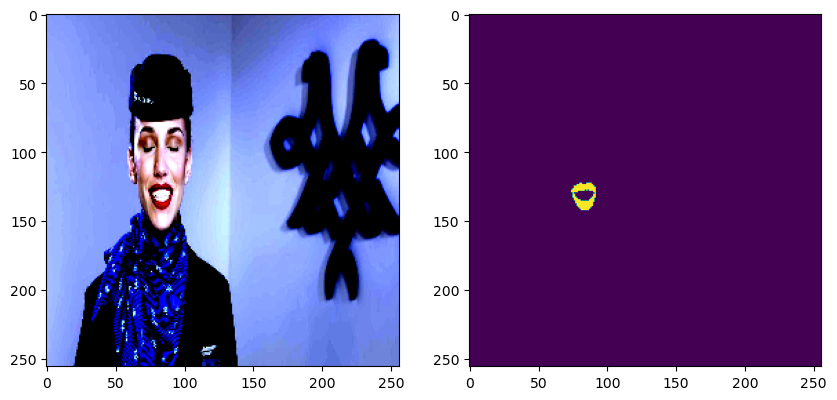

In [25]:
# проверяю размеры оригиналов и масок, вывожу пример пары: 

for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [26]:
# задаю функцию потерь, метрику и оптимизирующую функцию: 

criterion = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [27]:
# использую реализованные циклы обучения: 

train_epoch = utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [28]:
# обучение модели: 

max_score = 0

for i in range(1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model_2.pth')
        print('Model saved!') # сохранение модели

Epoch: 1
valid: 100%|██████████| 2141/2141 [06:47<00:00,  5.26it/s, dice_loss - 0.0323, iou_score - 0.939]  
Model saved!


In [29]:
# делаю предсказания: 

data_iter = iter(train_loader)

images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

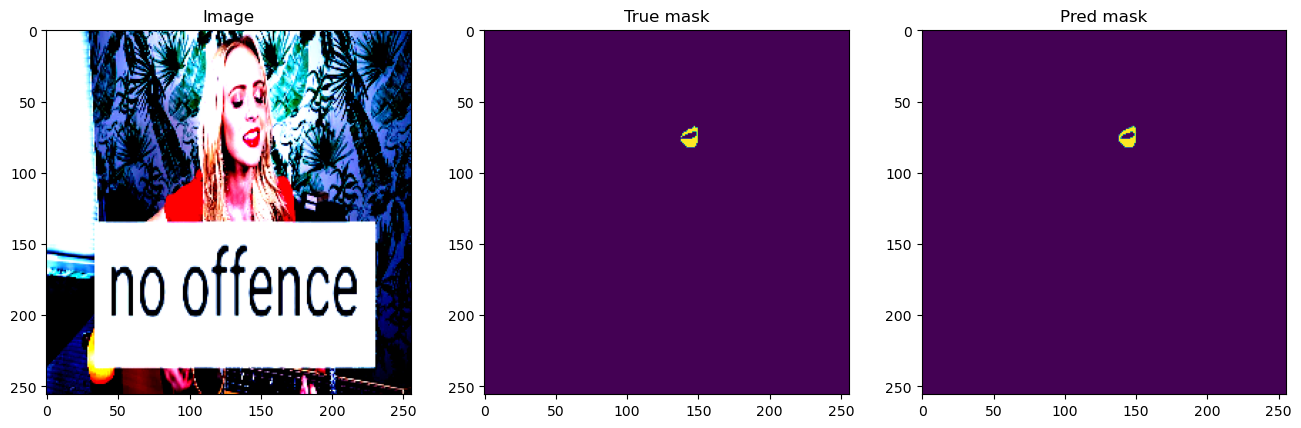

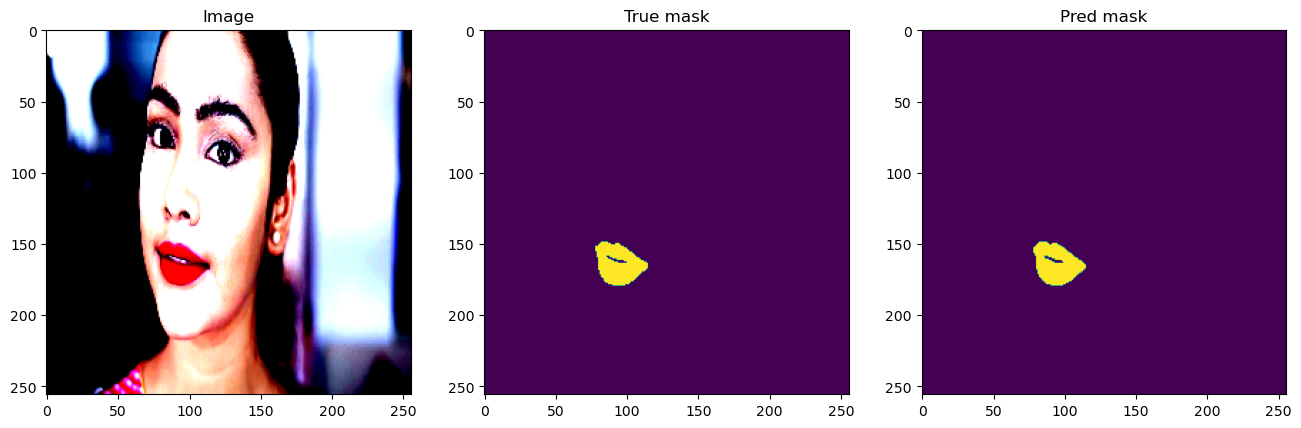

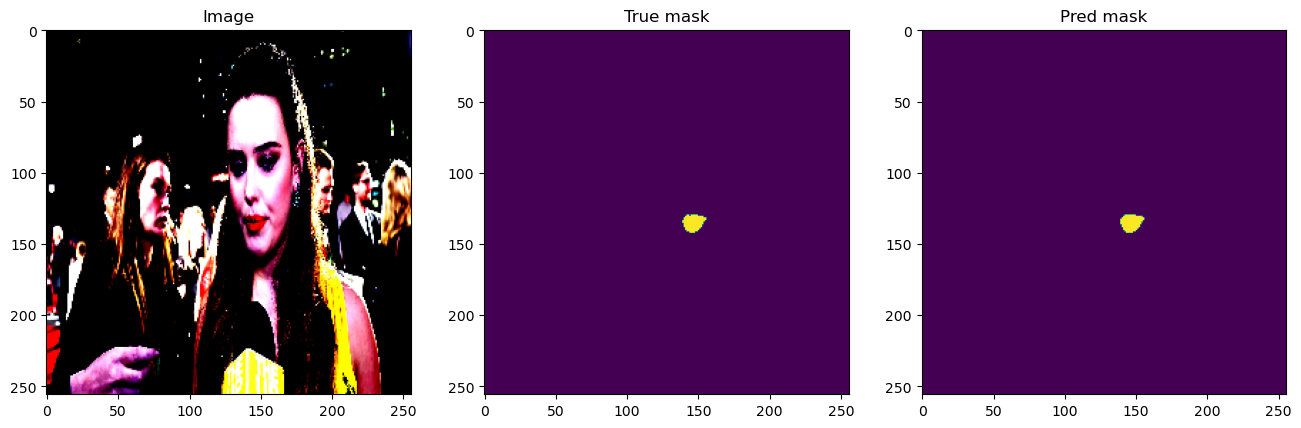

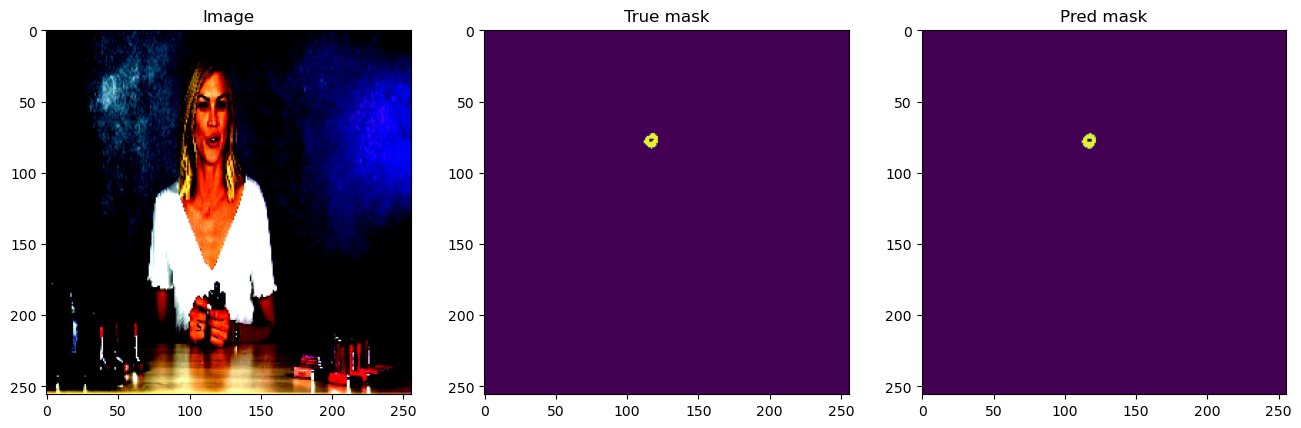

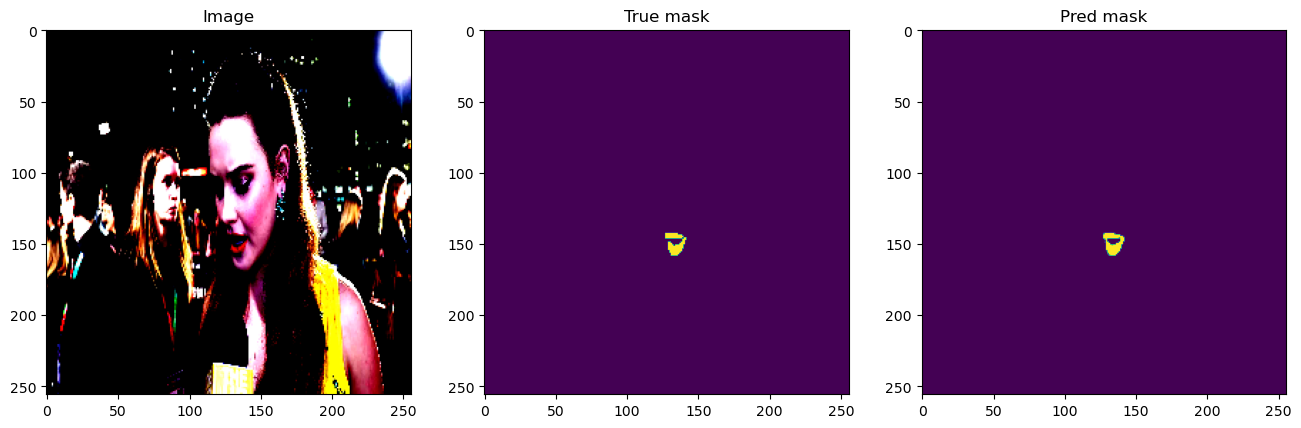

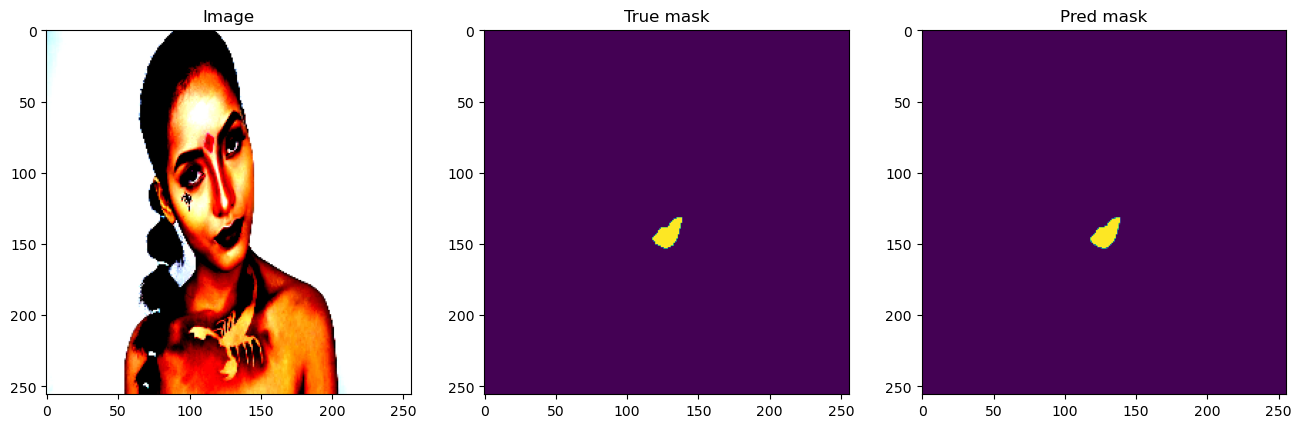

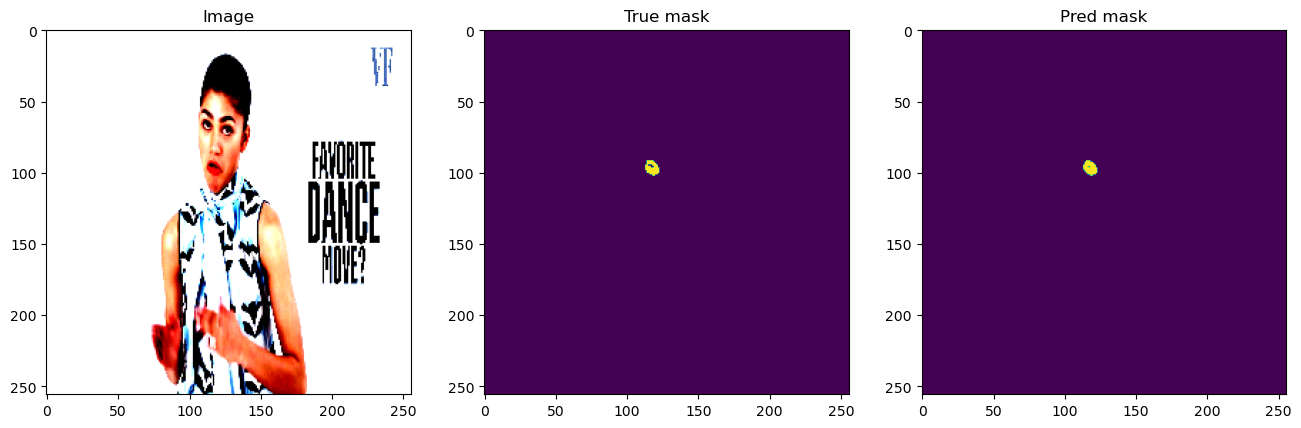

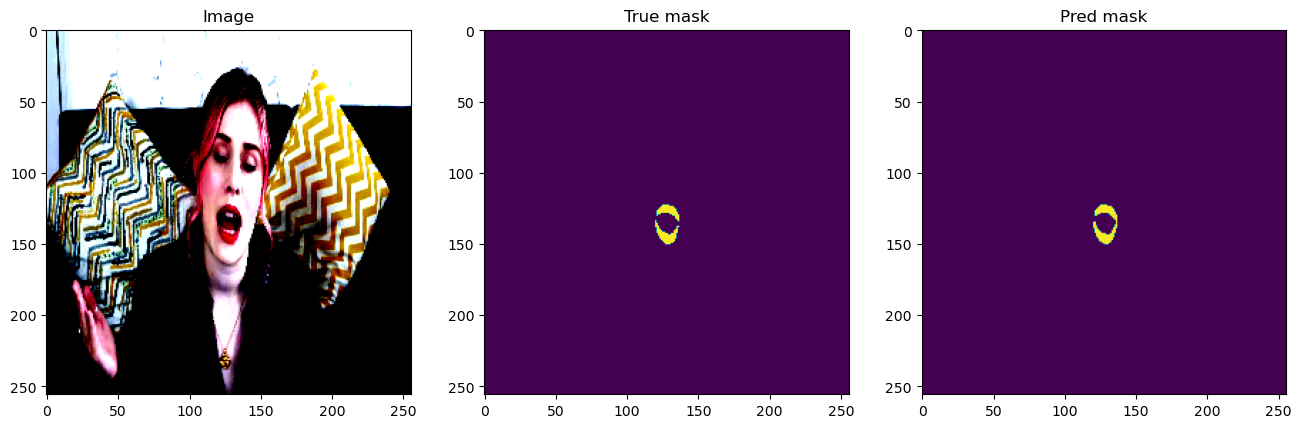

In [30]:
# отрисовываю результаты: 

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')

**vgg19/PSPNet:**

In [31]:
# определяю энкодер и модель: 
# теперь vgg19 и PSPNet: 

BACKBONE = 'vgg19'

segmodel = smp.PSPNet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [32]:
# разбиваю датасет на обучающую и валидационную выборки, сбрасываю индексы: 

X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [33]:
# создаю датасеты - экземпляры класса датасета LipsDataset: 

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [34]:
# создаю обучающий и валидационный даталоадер: 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


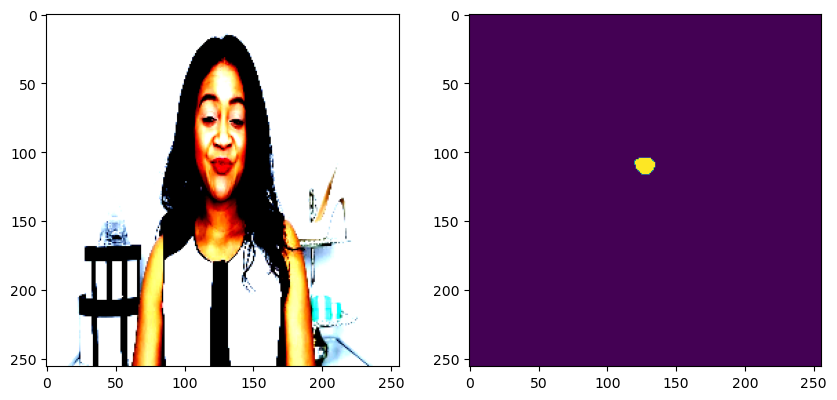

In [35]:
# проверяю размеры оригиналов и масок, вывожу пример пары: 

for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [36]:
# задаю функцию потерь, метрику и оптимизирующую функцию: 

criterion = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [37]:
# использую реализованные циклы обучения: 

train_epoch = utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [38]:
# обучение модели: 

max_score = 0

for i in range(1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model_3.pth')
        print('Model saved!') # сохранение модели

Epoch: 1
valid: 100%|██████████| 2141/2141 [06:36<00:00,  5.40it/s, dice_loss - 0.14, iou_score - 0.7591]  
Model saved!


In [39]:
# делаю предсказания: 

data_iter = iter(train_loader)

images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

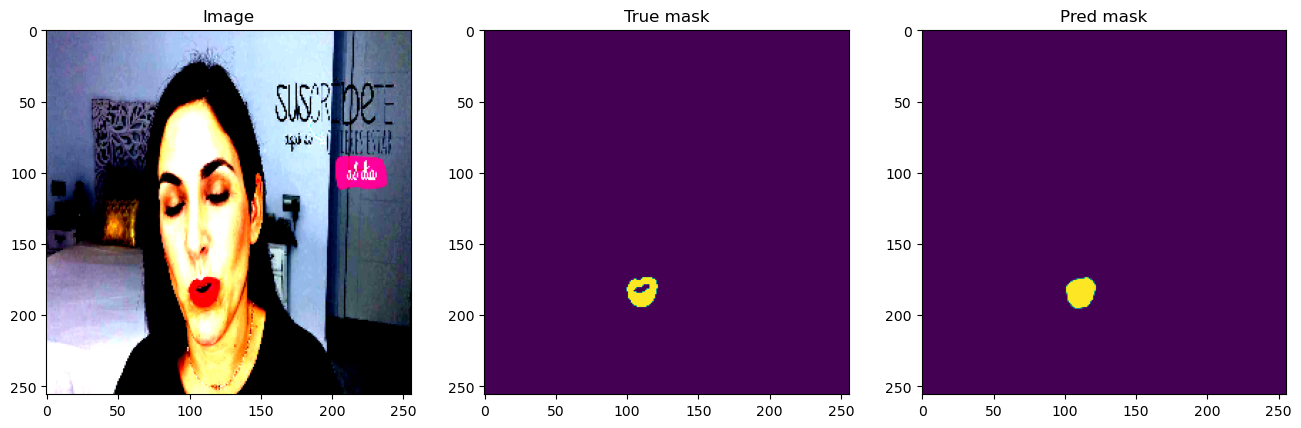

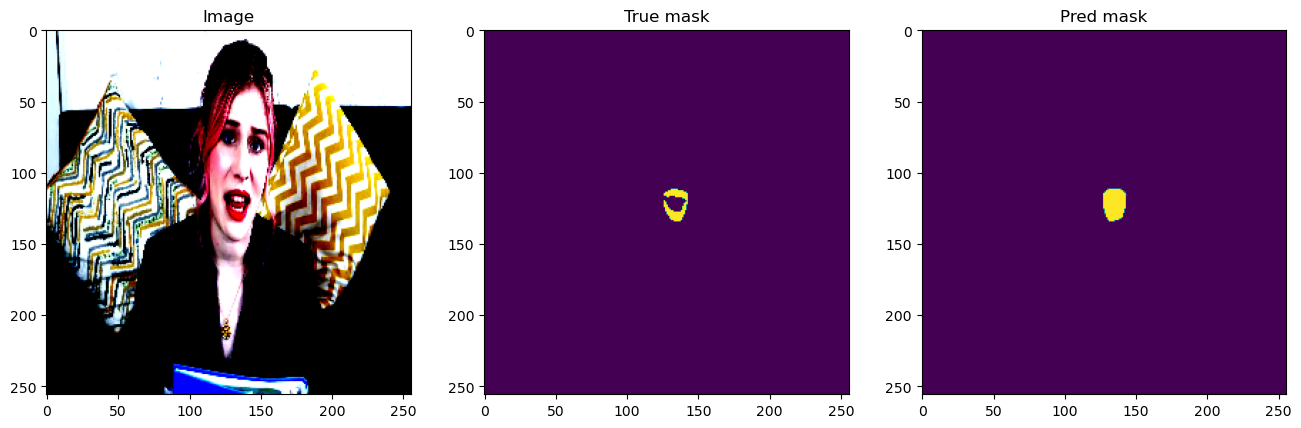

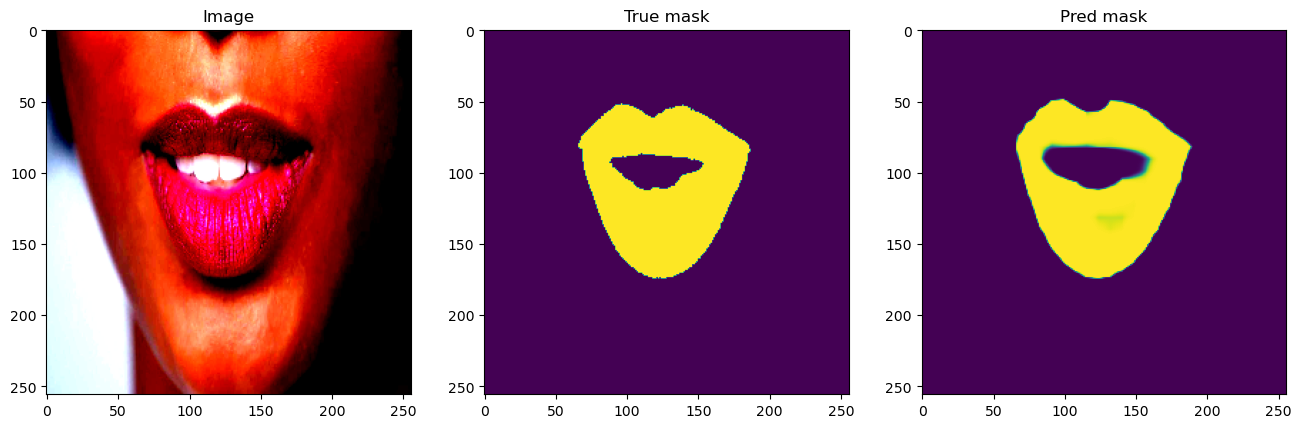

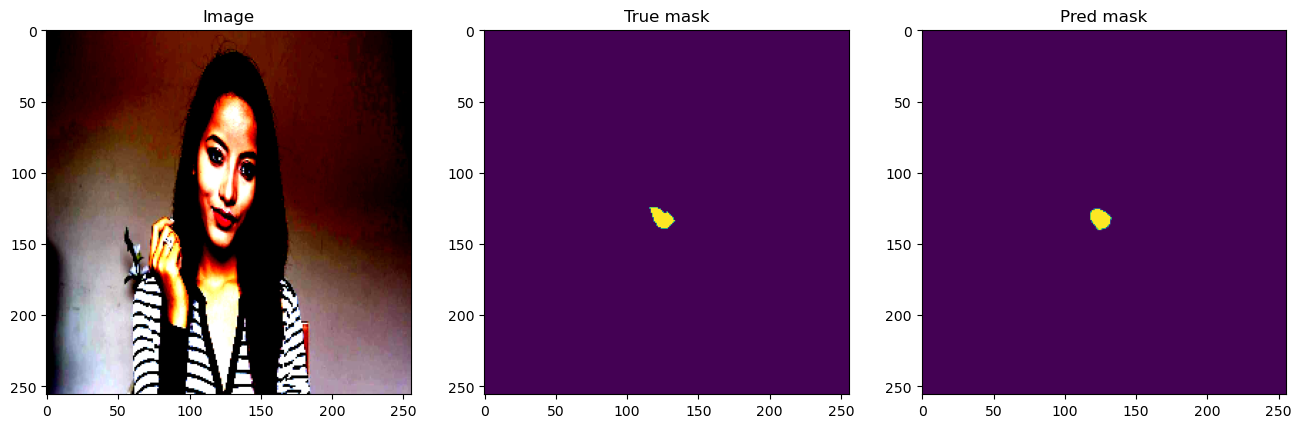

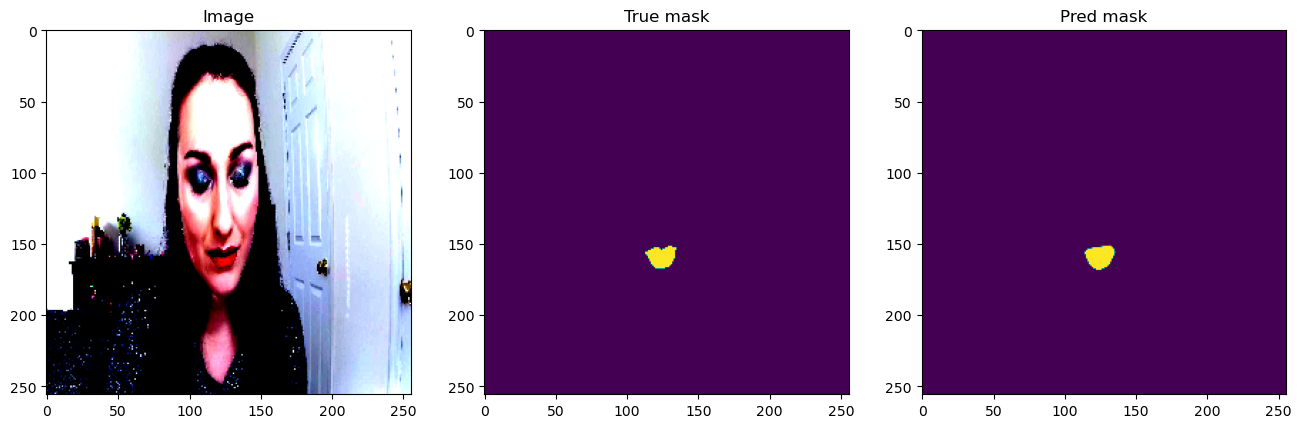

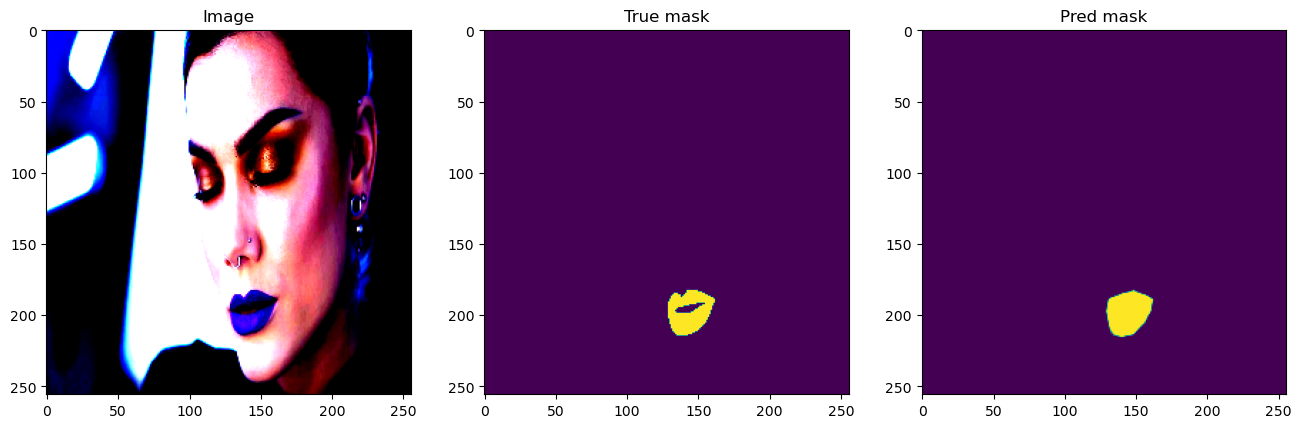

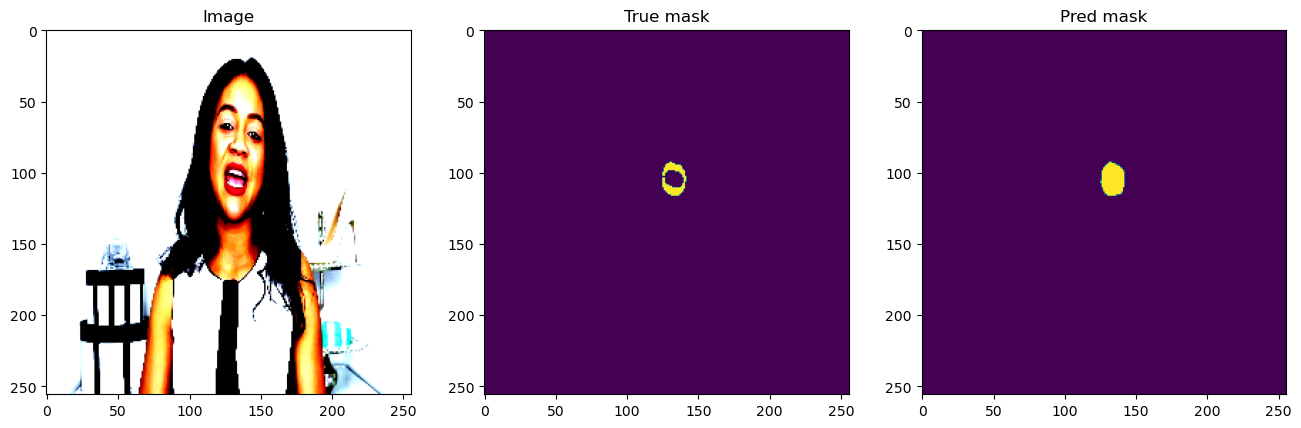

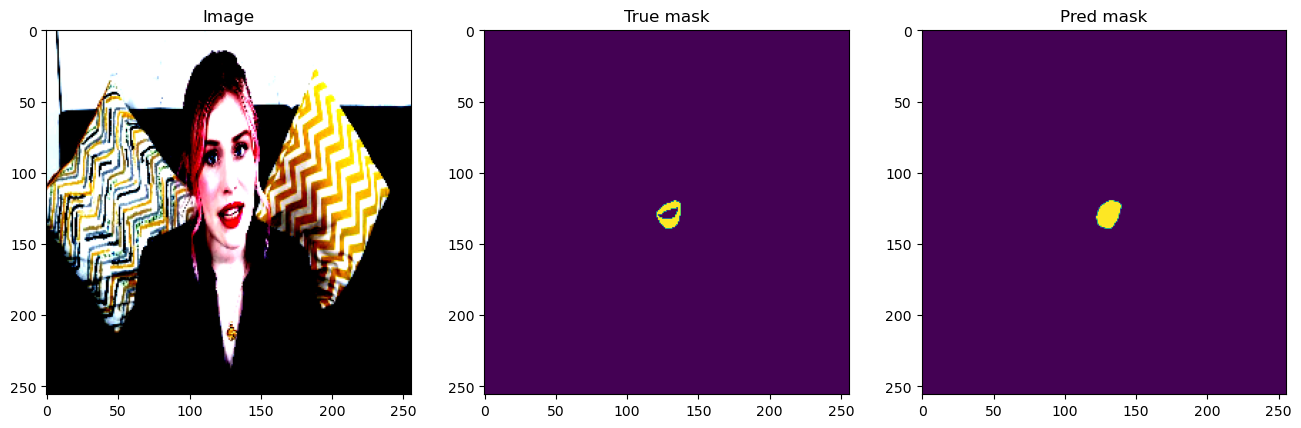

In [40]:
# отрисовываю результаты: 

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')

Итог: для задачи сегментации в PyTorch действительно хватает одной эпохи обучения модели - получены низкое значение функции потерь и высокое значение метрики как на обучающей выборке, так и на валидационной. 

Комбинации: 

resnet50/Unet (dice_loss - 0.0706, iou_score - 0.876), 

vgg19/Unet (dice_loss - 0.0323, iou_score - 0.939), 

vgg19/PSPNet (dice_loss - 0.14, iou_score - 0.7591) 

хоть с разными результатами, но в целом хорошо справились с задачей.